<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/Cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

In [0]:
# !pip install kaggle
# !mkdir .kaggle
# import json
# token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)
# !mkdir ~/.kaggle
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/content}
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d shayanfazeli/heartbeat -p /content
# !unzip /content/heartbeat.zip -d /content/heartbeat

Archive:  /content/heartbeat.zip
  inflating: /content/heartbeat/mitbih_test.csv  
  inflating: /content/heartbeat/mitbih_train.csv  
  inflating: /content/heartbeat/ptbdb_abnormal.csv  
  inflating: /content/heartbeat/ptbdb_normal.csv  


In [0]:

!pip3 install git+https://github.com/analysiscenter/cardio.git

In [0]:
import cardio
import wfdb
import tensorflow as tf

In [0]:
!unzip '/content/drive/My Drive/Cardio/training2017.zip'

In [0]:
########## traingng 2017 ########
import sys
import numpy as np

from matplotlib import pyplot as plt

sys.path.append('/content/training2017')

import cardio.batchflow as bf
index = bf.FilesIndex(path='/content/training2017/A*.hea', no_ext=True, sort=True)

In [88]:
print(index.indices)

['A00001' 'A00002' 'A00003' ... 'A08526' 'A08527' 'A08528']


In [0]:
from cardio import EcgBatch
eds = bf.Dataset(index, batch_class=EcgBatch)

In [0]:
from cardio import EcgDataset
eds = EcgDataset(path='/content/training2017/*.hea', no_ext=True, sort=True)

In [0]:
batch = eds.next_batch(batch_size=8528, unique_labels=['A', 'N', 'O'])

In [0]:
batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

In [0]:
batch_with_data = batch_with_data.load(src='/content/training2017/REFERENCE.csv', fmt='csv', components='target')

In [243]:
print(batch_with_data['A00004'].signal.shape)
print(batch_with_data['A00004'].target)
print(batch_with_data['A00004'].signal)

(1, 9000)
A
[[0.519 0.619 0.723 ... 0.116 0.017 0.018]]


In [244]:
dataset = np.zeros((9279, 9001))
pointer = 0
skip = 0 
for ecg in batch_with_data:
  
  
  if ecg.signal.shape[1] == 18000:
      dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]

      ### pointer+2 for next slice ###

      if ecg.target == 'A':
        dataset[pointer:pointer+2, 9000:9001] = 1
      elif ecg.target == 'N':
        dataset[pointer:pointer+2, 9000:9001] = 2
      else:
        dataset[pointer:pointer+2, 9000:9001] = 3
        
        
      ###### next slice ######

      pointer += 1
      dataset[pointer:pointer+1, :9000] = ecg.signal[:1, 9000:18000]
      pointer += 1 
      
      ## target column is already filled ##

  elif ecg.signal.shape[1] == 9000:
      
      dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]

      if ecg.target == 'A':
        dataset[pointer:pointer+1, 9000:9001] = 1
      elif ecg.target == 'N':
        dataset[pointer:pointer+1, 9000:9001] = 2
      else:
        dataset[pointer:pointer+1, 9000:9001] = 3
      
      pointer += 1

  else: 
    skip += 1

print(skip)



1742


In [0]:

trainset = np.zeros((7594, 9001))
trainset = dataset[:7594, :]

# some of the signals are skipped because of different dimentions

[[0.519 0.619 0.723 ... 0.116 0.017 0.018]]
[[1.]]


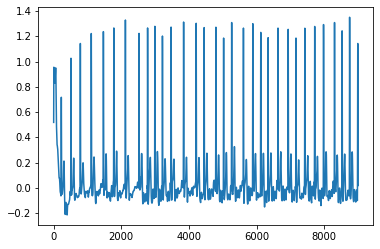

In [265]:
import matplotlib.pyplot as plt

# signal in trainset 
x = trainset[4:5, :-1]
target = trainset[4:5, -1:] 
plt.plot(x[0])
plt.show
print(x)
print(target)

In [0]:
X = trainset[:, :-1]
Y = trainset[:, -1:].reshape(7594, )

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state= 40)


In [0]:
X_train = np.array(X_train.reshape(6834, 9000, 1))
X_test = np.array(X_test.reshape(760, 9000, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [319]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (6834, 9000, 1)
y_train (6834,)
X_test (760, 9000, 1)
y_test (760,)


In [0]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [321]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (6834, 9000, 1)
y_train (6834, 3)
X_test (760, 9000, 1)
y_test (760, 3)


In [0]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, Flatten, Dense, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [0]:
m, feature, depth = X_train.shape
batch_size = 32

X_input = Input(shape=(feature, depth))
Conv = Conv1D(filters=32, kernel_size=5, strides=1)(X_input)


### step 1 

Conv1_1 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(Conv)
Bn1_1 = BatchNormalization()(Conv1_1)
Act1_1 = Activation("relu")(Bn1_1)
Conv1_2 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(Act1_1)
Bn1_2 = BatchNormalization()(Conv1_2)
Act1_2 = Activation("relu")(Bn1_2)
Conv1_3 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(Act1_2)
Bn1_3 = BatchNormalization()(Conv1_3)
shortcut1_1 = Add()([Bn1_3, Conv])
Act1_3 = Activation("relu")(shortcut1_1)
Max1_1 = MaxPooling1D(pool_size=5, strides=2)(Act1_3)


## step 2

Conv2_1 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(Max1_1)
Bn2_1 = BatchNormalization()(Conv2_1)
Act2_1 = Activation("relu")(Bn2_1)
Conv2_2 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(Act2_1)
Bn2_2 = BatchNormalization()(Conv2_2)
Act2_2 = Activation("relu")(Bn2_2)
Conv2_3 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(Act2_2)
Bn2_3 = BatchNormalization()(Conv2_3)
shortcut2_1 = Add()([Bn2_3, Max1_1])
Act2_3 = Activation("relu")(shortcut2_1)
Max2_1 = MaxPooling1D(pool_size=5, strides=2)(Act2_3)


## step 3

Conv3_1 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(Max2_1)
Bn3_1 = BatchNormalization()(Conv3_1)
Act3_1 = Activation("relu")(Bn3_1)
Conv3_2 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(Act3_1)
Bn3_2 = BatchNormalization()(Conv3_2)
Act3_2 = Activation("relu")(Bn3_2)
Conv3_3 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(Act3_2)
Bn3_3 = BatchNormalization()(Conv3_3)
shortcut3_1 = Add()([Bn3_3, Max2_1])
Act3_3 = Activation("relu")(shortcut3_1)
Max3_1 = MaxPooling1D(pool_size=5, strides=2)(Act3_3)


## step 4

Conv4_1 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(Max3_1)
Bn4_1 = BatchNormalization()(Conv4_1)
Act4_1 = Activation("relu")(Bn4_1)
Conv4_2 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(Act4_1)
Bn4_2 = BatchNormalization()(Conv4_2)
Act4_2 = Activation("relu")(Bn4_2)
Conv4_3 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(Act4_2)
Bn4_3 = BatchNormalization()(Conv4_3)
shortcut4_1 = Add()([Bn4_3, Max3_1])
Act4_3 = Activation("relu")(shortcut4_1)
Max4_1 = MaxPooling1D(pool_size=5, strides=2)(Act4_3)


## step 5

Conv5_1 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(Max4_1)
Bn5_1 = BatchNormalization()(Conv5_1)
Act5_1 = Activation("relu")(Bn5_1)
Conv5_2 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(Act5_1)
Bn5_2 = BatchNormalization()(Conv5_2)
Act5_2 = Activation("relu")(Bn5_2)
Conv5_3 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(Act5_2)
Bn5_3 = BatchNormalization()(Conv5_3)
shortcut5_1 = Add()([Bn5_3, Max4_1])
Act5_3 = Activation("relu")(shortcut5_1)
Max5_1 = MaxPooling1D(pool_size=5, strides=2)(Act5_3)



Flat1 = Flatten()(Max5_1)

D1 = Dense(64)(Flat1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(3)(D2)
A7 = Softmax()(D3)

model = Model(inputs=X_input, outputs=A7)

model.summary()



In [0]:
from scipy.sparse import csr_matrix
y_train = csr_matrix.toarray(y_train)
y_test = csr_matrix.toarray(y_test)

In [0]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [326]:
# train more epochs to increase accuracy 
num_epochs = 10 # 75

# Train Model

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
428/428 [==============================] - 1245s 3s/step - loss: 1.4384 - accuracy: 0.5806 - val_loss: 0.8310 - val_accuracy: 0.6276
Epoch 2/10
428/428 [==============================] - 1233s 3s/step - loss: 0.7962 - accuracy: 0.6157 - val_loss: 0.7850 - val_accuracy: 0.6171
Epoch 3/10
428/428 [==============================] - 1233s 3s/step - loss: 0.7436 - accuracy: 0.6362 - val_loss: 0.7331 - val_accuracy: 0.6526
Epoch 4/10
428/428 [==============================] - 1217s 3s/step - loss: 0.7181 - accuracy: 0.6567 - val_loss: 0.7209 - val_accuracy: 0.6645
Epoch 5/10
428/428 [==============================] - 1175s 3s/step - loss: 0.6897 - accuracy: 0.6716 - val_loss: 0.6503 - val_accuracy: 0.6961
Epoch 6/10
428/428 [==============================] - 1188s 3s/step - loss: 0.6792 - accuracy: 0.6835 - val_loss: 0.7774 - val_accuracy: 0.6539
Epoch 7/10
428/428 [==============================] - 1205s 3s/step - loss: 0.6774 - accuracy: 0.6911 - val_loss: 0.7984 - val_accuracy: